In [8]:
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply, Dropout, Input

from sklearn.model_selection import train_test_split

import json

In [9]:
import os

In [10]:
from google.colab import files

In [13]:
!cp /content/drive/MyDrive/Colab\ Notebooks/include/sca_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/tuning_utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/include/data_utils.py /content/

In [14]:
!ls /content/ | grep utils

data_utils.py
sca_utils.py
tuning_utils.py


## Data loading

In [15]:
from data_utils import SyntheticDataLoader

In [5]:
TARGET_BYTE = 0
WINDOW_TO_USE = 0
profiling_file = "/content/drive/MyDrive/mbedtls_synthetic_traces/profiling_windows/byte_0.h5"
BATCH_SIZE = 128
EPOCHS = 50
VALIDATION_SPLIT = 0.2

In [16]:
profiling_data_loader = SyntheticDataLoader(profiling_file)

## CNN SE network

Based on the best results of CNN with SE layers on ASCAD dataset, construct the model to be used on synthetic data.

## CNN SE model definition

In [3]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Reshape, Multiply, Dropout, Input, Conv1D, BatchNormalization, MaxPooling1D, Flatten

def se_block(input_tensor, ratio=16):
  channels = input_tensor.shape[-1]
  se = GlobalAveragePooling1D()(input_tensor)
  se = Dense(channels // ratio, activation='relu')(se)
  se = Dense(channels, activation='sigmoid')(se)
  se = Reshape((1, channels))(se)
  return Multiply()([input_tensor, se])

In [4]:
def cnn_squeeze_excite(filters, se_ratio, dropout_rate, classes=256,input_dim=700, batch_normalize=False):
    # From VGG16 design
    input_shape = (input_dim,1)
    img_input = Input(shape=input_shape)
    # Block 1
    x = Conv1D(filters[0], 11, activation='relu', padding='same', name='block1_conv1')(img_input)
    if batch_normalize:
        x = BatchNormalization()(x)
    # Block 2
    x = Conv1D(filters[1], 11, activation='relu', padding='same', name='block2_conv1')(x)
    if batch_normalize:
        x = BatchNormalization()(x)
    # Squeeze excitation block 1
    x = se_block(x, ratio=se_ratio)
    x = MaxPooling1D(2)(x)

    # Block 3
    x = Conv1D(filters[2], 11, activation='relu', padding='same', name='block3_conv1')(x)
    if batch_normalize:
        x = BatchNormalization()(x)
    # Block 4
    x = Conv1D(filters[3], 11, activation='relu', padding='same', name='block4_conv1')(x)
    if batch_normalize:
        x = BatchNormalization()(x)
  # Block 5
    x = Conv1D(filters[4], 11, activation='relu', padding='same', name='block5_conv1')(x)
    if batch_normalize:
        x = BatchNormalization()(x)
    # Squeeze excitation block 1
    x = se_block(x, ratio=se_ratio)
    x = MaxPooling1D(2)(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(1024, activation='relu', name='fc2')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='cnn_squeeze_excitation')

    # model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

### Training

Perform a sanity-check training.

In [ ]:
ds_train, ds_full_val, input_dim, train_size, val_size = profiling_data_loader.create_dataset(
        window_index=WINDOW_TO_USE,
        batch_size=BATCH_SIZE,
        val_split=VALIDATION_SPLIT
    )

Dataset created from 'byte_0.h5':
  - Total samples: 50001
  - Training samples: 40001
  - Validation samples: 10000


In [ ]:
model = cnn_squeeze_excite(
        filters=[32, 64, 128, 128, 128],
        se_ratio=8,
        dropout_rate=0.5,
        classes=256,
        input_dim=input_dim,
        batch_normalize=True
    )

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
checkpoint_path = f"/content/drive/MyDrive/mbedtls_synthetic_traces/CNN_SE_byte{TARGET_BYTE}.keras"
model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
ds_val_for_fit = ds_full_val.map(lambda trace, label, pt, key: (trace, label))
print("\n--- Starting Model Training ---")
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val_for_fit,
    steps_per_epoch=steps_per_epoch,
    callbacks=[model_checkpoint, early_stopping]
)

print("\n--- Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0054 - loss: 5.5442
Epoch 1: val_accuracy improved from 0.00370 to 0.00460, saving model to /content/drive/MyDrive/mbedtls_synthetic_traces/CNN_SE_byte0.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 158ms/step - accuracy: 0.0054 - loss: 5.5442 - val_accuracy: 0.0046 - val_loss: 5.5438
Epoch 2/50
  1/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.0000e+00 - loss: 5.5474
Epoch 2: val_accuracy improved from 0.00460 to 0.00500, saving model to /content/drive/MyDrive/mbedtls_synthetic_traces/CNN_SE_byte0.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.0000e+00 - loss: 5.5474 - val_accuracy: 0.0050 - val_loss: 5.5437
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0051 - loss: 5.5437
Epoch 3: val_accuracy did not improve from 0.00500
312/312 ━━━━━━━━━━━━━━━━━━━━ 58s 168ms/step - accuracy: 0.0051 - loss: 5.5437 - val_accuracy: 0.0041 - val_loss: 5.5435
Epoch 4/5

## Rank evaluation - sanity check

In [ ]:
from sca_utils import run_rank_trials, plot_mean_rank
from sca_utils import SBOX

In [ ]:
ds_val_for_predict = ds_full_val.map(lambda trace, label, pt, key: trace)
predictions = model.predict(ds_val_for_predict)

metadata_for_ranking = []
# Iterate through the original, complete validation dataset
# Create the full metadata structures rank eval functions expect
for _, _, pt, key in ds_full_val.unbatch():
    full_key = np.zeros(16, dtype=np.uint8)
    full_key[TARGET_BYTE] = key.numpy()
    full_pt = np.zeros(16, dtype=np.uint8)
    full_pt[TARGET_BYTE] = pt.numpy()
    metadata_for_ranking.append({'plaintext': full_pt, 'key': full_key})

79/79 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Trials: 100%|██████████| 10/10 [04:20<00:00, 26.03s/it]


Plotting mean rank...


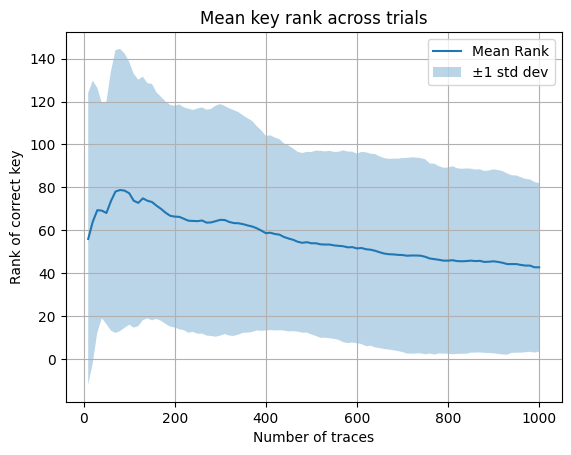

In [ ]:
steps, ranks = run_rank_trials(
        predictions,
        metadata_for_ranking,
        n_traces_per_trial=min(1000, val_size),
        n_trials=10,
        target_byte=TARGET_BYTE
    )

print("Plotting mean rank...")
plot_mean_rank(steps, ranks)

## Hyperparameter search

Given that the architecture is set; focus on the other hyperparameter search

In [1]:
!pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.3 MB/s eta 0:00:00


In [17]:
from tuning_utils import CleanMemoryTuner
from tuning_utils import model_builder_synthetic_se_cnn

In [18]:
from data_utils import SyntheticDataLoader

In [ ]:
# BYTES_TO_TUNE = [0] # TODO: (08/01/2025) -
# BYTES_TO_TUNE = [1, 2, 3, 4, 5] #TODO: (08/02/2025) , 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
BYTES_TO_TUNE = [4, 5, 6] #TODO: (08/02/2025) 7, 8, 9, 10, 11, 12, 13, 14, 15]
WINDOW_TO_USE = 0
BATCH_SIZE = 128
EPOCHS_PER_TRIAL = 25
MAX_TRIALS = 10
EXECUTIONS_PER_TRIAL = 1
BASE_DIR_SYNTHETIC = "/content/drive/MyDrive/mbedtls_synthetic_traces"
TUNER_DIRECTORY = f"{BASE_DIR_SYNTHETIC}/cnn_se_tuning"

for target_byte in BYTES_TO_TUNE:
    print(f"\n\n{'='*60}")
    print(f"--- STARTING HYPERPARAMETER SEARCH FOR BYTE {target_byte} ---")
    print(f"{'='*60}\n")

    profiling_data_loader = None
    H5_FILE_PATH = f'{BASE_DIR_SYNTHETIC}/profiling_windows/byte_{target_byte}.h5'
    if not os.path.exists(H5_FILE_PATH):
        print(f"Creating dummy HDF5 file for byte {target_byte}: {H5_FILE_PATH}")
        with h5py.File(H5_FILE_PATH, 'w') as f:
            f.create_dataset('windows', data=np.random.rand(50000, 5, 701).astype(np.float32))
            f.create_dataset('labels', data=np.random.randint(0, 256, size=50000).astype(np.int32))
    else:
        profiling_data_loader = SyntheticDataLoader(H5_FILE_PATH)

    # --- Create Datasets for the current byte ---
    ds_train, ds_val, input_dimension, _, _ = profiling_data_loader.create_dataset(
        window_index=WINDOW_TO_USE,
        batch_size=BATCH_SIZE
    )

    # --- Instantiate the Tuner for the current byte ---
    tuner = CleanMemoryTuner(
        hypermodel=lambda hp: model_builder_synthetic_se_cnn(
            hp,
            model_fun=cnn_squeeze_excite,
            input_dim=input_dimension
        ),
        objective="val_accuracy",
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=TUNER_DIRECTORY,
        project_name=f"tuning_byte_{target_byte}",
        overwrite=True
    )

    tuner.search_space_summary()

    # --- Define Callbacks ---
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # --- Run the Search ---
    print(f"\n--- Running search for byte {target_byte} ---")
    ds_val_for_fit = ds_val.map(lambda trace, label, pt, key: (trace, label))
    tuner.search(
        ds_train,
        validation_data=ds_val_for_fit,
        epochs=EPOCHS_PER_TRIAL,
        callbacks=[early_stop]
    )

    # --- Get and Print Best Hyperparameters ---
    print(f"\n--- SEARCH COMPLETE FOR BYTE {target_byte} ---")
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"""
    Best hyperparameters for byte {target_byte}:
    - Filter Scale: {best_hps.get('filter_scale')}
    - Dropout Rate: {best_hps.get('dropout'):.4f}
    - SE Ratio: {best_hps.get('se_ratio')}
    - Batch Normalization: {best_hps.get('batch_normalize')}
    - Learning Rate: {best_hps.get('learning_rate')}
    """)

Trial 4 Complete [00h 23m 25s]
val_accuracy: 0.5338000059127808

Best val_accuracy So Far: 0.9083999991416931
Total elapsed time: 01h 13m 56s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
0.5               |1                 |filter_scale
0.2               |0.2               |dropout
8                 |8                 |se_ratio
True              |True              |batch_normalize
rmsprop           |rmsprop           |optimizer
0.001             |0.0001            |learning_rate

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 182ms/step - accuracy: 0.0048 - loss: 6.0421 - val_accuracy: 0.0048 - val_loss: 5.5438
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.0045 - loss: 5.5477 - val_accuracy: 0.0035 - val_loss: 5.5437
Epoch 3/25
205/313 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.0044 - loss: 5.5464